# AML Data Preprocessing
- Using the IBM dataset for AML: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml
- Dataset is generated by IBM Box Generator, models transactions and illicit activities.
- Original dataset for training will be extensively large, for initial stages of thesis, using smaller dataset of 500,000 transactions.
- In the following we will:
1. explore the data
2. determine nodes and edges
3. determine node and edge attributes
4. create visualization using NetworkX, PyVis, or Graph-tool

* Attributes on ACCOUNT
    * Bank account
    * Account balance
    * BIN number
    * Number of transactions (calculated)
    * Receiving Currency
* Attributes on TRANSACTIONS
    * Payment amount
    * Payment Type
    * Payment Currency (based on “receiving currency” of outgoing bank account)
    * Time


## BASICS

### --- IMPORT LIBRARIES --- 

In [ ]:
! pip3 install torch numpy pandas matplotlib torch-geometric

In [ ]:
import torch
import time
import random
import hashlib
import datetime
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from pandas import Timestamp
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

### --- LOAD DATASET --- 

In [ ]:
filename = "/Users/owhy/Documents/Datasets/HI-Small_Trans.csv"

In [ ]:
data = pd.read_csv(filename)
data.head()

In [ ]:
print(f"---- shape ----\n - {data.shape}")

In [ ]:
print("---- info ----")
data.info()

In [ ]:
print("---- basic calculations ----")
data.describe()

## NODE MATRIX

Nodes = Bank Accounts -- bank account number
* BIN Number
* Receiving Currency

* Number of transactions (degree matrix --> calculated based on incoming and outcoming flows)

Edges = transactions -- payment amount
* Payment Type
* Payment Currency
* Date and Time

* Account Balance (before transactions)

In [ ]:
data

In [ ]:
### merging all accounts and getting unique values

# Merge "Account" and "Account.1" columns
merged_accounts = pd.concat([data['Account'], data['Account.1']])

# Merge "From Bank" and "To Bank" columns
merged_banks = pd.concat([data['From Bank'], data['To Bank']])

# Merge "Receiving Currency" and "Payment Currency" columns
merged_currencies = pd.concat([data['Receiving Currency'], data['Payment Currency']])

# Create a new DataFrame with merged columns
merged_df = pd.DataFrame({
    'Accounts': merged_accounts,
    'Bank': merged_banks,
    'Currency': merged_currencies
})

merged_df


In [ ]:
# Drop duplicates based on the "Accounts" column to ensure uniqueness
unique_accounts = merged_df.drop_duplicates(subset=['Accounts']).reset_index(drop=True)
unique_accounts

#### --- One-hot encoding: currency ---

In [ ]:
# Convert non-numeric columns
positions = unique_accounts["Currency"].str.split(",", expand=True) # creating new columns by splitting receiving currency --> all are added
unique_accounts["first_position"] = positions[0] # first currency in each row is extracted --> actual currency used and that we want as TRUE
# One-hot encoding 
node_features = pd.concat([unique_accounts, pd.get_dummies(unique_accounts["first_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
node_features.drop(["Currency", "first_position"], axis=1, inplace=True) # drop the axiliary columns
node_features.head()

# TODO-DONE! conc unnique random number to the end --> maintain uniqueness
# TODO-DONE! node --> feature --> feature2 --> node2 | problem with uniqueness of node embeddings --> add unique value to identify the node feature vector
# TODO-DONE! create random identity vector for each ACCOUNT + add Account and From Bank as separate properties of the node
# TODO-DONE! ultimately normalize From bank
# TODO-DONE! feature matrix -- > receiving currency n-hot encoding (0 and 1) + encoding of From Bank and Account (word2vec)
# TODO add edge features --> look into EDGE LABELED GRAPHS where all nodes and edges have labels
# TODO create init for loading graph --> initial step


#### --- Normalization and Vectorization ---

In [ ]:
# Normalize 'From Bank' & 'Account'
def normalize(table, new_min=0, new_max=10):
    if len(table.columns) == 1:
        normalized_df = ((table - table.min()) / (table.max() - table.min())) * (new_max - new_min) + new_min
        return normalized_df
    else:
        normalized_df = pd.DataFrame()
        id = 0
        for column in table.columns:
            col_data = table[column]
            if id == 0:
                normalized_df[f'col_{id}'] = ((col_data - col_data.min()) / (col_data.max() - col_data.min())) * (new_max - new_min) + new_min
            else:
                normalized_column = ((col_data - col_data.min()) / (col_data.max() - col_data.min())) * (new_max - new_min) + new_min
                normalized_df[f'col_{id}'] = normalized_column
            id += 1
        # print(normalized_df)
        return normalized_df

def hashing_vectorization(strings, vector_size=9):
    vectors = []
    for string in strings:
        # Hash the string using hash()
        hashed_values = hash(string) % (10 ** vector_size)  # Ensures unique representations within the specified range
        
        # Convert hashed values to a fixed-size vector
        vector = [int(digit) for digit in str(hashed_values)]
        
        # Ensure vector has the desired size by zero-padding or truncating
        if len(vector) < vector_size:
            vector = [0] * (vector_size - len(vector)) + vector
        elif len(vector) > vector_size:
            vector = vector[:vector_size]
        
        vectors.append(vector)
    
    return vectors

In [ ]:
from_bank_col = node_features.pop('Bank')
account_col = node_features.pop('Accounts')

In [ ]:
# node labels for later use

node_labels = pd.DataFrame(account_col)
node_labels

In [ ]:
# TODO add vectors as individuals columns in new dataframe

df = pd.DataFrame(account_col, columns=['Accounts'])
df.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series
vectors = hashing_vectorization(df['Accounts'], vector_size=9) 

# Convert vectors into DataFrame
vectors_df = pd.DataFrame(vectors, columns=[f'col_{i}' for i in range(len(vectors[0]))])
result_df = pd.concat([df, vectors_df], axis=1)

In [60]:
accounts_df = result_df.drop(columns=["Accounts"])

In [49]:
from_bank_col

0             10
1           3208
2           3209
3             12
4             10
           ...  
515075    152627
515076     13917
515077    219969
515078     25534
515079    248571
Name: Bank, Length: 515080, dtype: int64

In [53]:
from_bank_binary = [bin(x).split("b")[1] for x in from_bank_col]
# vectors_df = pd.DataFrame(vectors, columns=[f'col_{i}' for i in range(len(vectors[0]))])

res = max(from_bank_binary, key=len) 
print("Longest String is  : ", res)
len(res)

from_bank_binary

Longest String is  :  1001011101011111101


['1010',
 '110010001000',
 '110010001001',
 '1100',
 '1010',
 '1',
 '1',
 '1',
 '1100',
 '1',
 '1',
 '1',
 '1',
 '1010',
 '1100',
 '1',
 '1010',
 '10110001100',
 '11010000001',
 '11010000001',
 '10110001100',
 '1010',
 '1100',
 '1010',
 '1110001100',
 '10110001100',
 '11010011000',
 '1',
 '1010',
 '111100110010101',
 '1010',
 '10110001100',
 '10100001100',
 '11010001010',
 '101010001101011',
 '10101110010101',
 '1010',
 '10110000100000',
 '10110011010010',
 '11001000001',
 '10110000011',
 '10110111011',
 '10011011001',
 '10110001100',
 '10110001100',
 '11010001010',
 '10000101100',
 '10110000011',
 '10110110001',
 '10110000110110',
 '1',
 '1',
 '10110111011',
 '1100',
 '11010010110',
 '10000010111',
 '101111101011',
 '11010000001',
 '10110000100000',
 '101110100100010',
 '10111010000000',
 '11010000001111',
 '11011100',
 '1010111101',
 '1010',
 '101110101111',
 '101100011101',
 '10011011100',
 '11010010110',
 '10000101100',
 '101110100011001',
 '10111010000000',
 '101001100001010',
 '1

In [54]:
def make_binary_fixed_length(binary_lists, res):
    new_binary_list = []
    for x in binary_lists:
        # print(x)
        if len(x) < len(res):
            num_zeros = len(res) - len(x)
            x = [0] * num_zeros + x
            # print(x)
            new_binary_list.append(x)
        else:
            new_binary_list.append(x)
    return new_binary_list

In [55]:
binary_lists = [[int(bit) for bit in binary] for binary in from_bank_binary]
binary_lists = make_binary_fixed_length(binary_lists, res)
binary_lists

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [56]:
# Convert vectors into DataFrame
bin_vectors_df = pd.DataFrame(binary_lists, columns=[f'bin_{i}' for i in range(len(binary_lists[0]))])
bin_vectors_df

bin_0  bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  bin_7  bin_8  bin_9  \
0           0      0      0      0      0      0      0      0      0      0   
1           0      0      0      0      0      0      0      1      1      0   
2           0      0      0      0      0      0      0      1      1      0   
3           0      0      0      0      0      0      0      0      0      0   
4           0      0      0      0      0      0      0      0      0      0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
515075      0      1      0      0      1      0      1      0      1      0   
515076      0      0      0      0      0      1      1      0      1      1   
515077      0      1      1      0      1      0      1      1      0      1   
515078      0      0      0      0      1      1      0      0      0      1   
515079      0      1      1      1      1      0      0      1      0      1   

        bin_10  bin_11  bin_12  bin_13  bin_14  bin_15  bin_16  bin_17  bin_18  
0            0       0       0       0       0       1       0       1       0  
1            0       1       0       0       0       1       0       0       0  
2            0       1       0       0       0       1       0       0       1  
3            0       0       0       0       0       1       1       0       0  
4            0       0       0       0       0       1       0       1       0  
...        ...     ...     ...     ...     ...     ...     ...     ...     ...  
515075       0       0       0       1       1       0       0       1       1  
515076       0       0       1       0       1       1       1       0       1  
515077       1       0       1       0       0       0       0       0       1  
515078       1       1       0       1       1       1       1       1       0  
515079       0       1       1       1       1       1       0       1       1  

[515080 rows x 19 columns]

In [64]:
# TODO normalize vector values to avoid big numbers

from_bank_df = pd.DataFrame(from_bank_col)
accounts_df = pd.DataFrame(accounts_df)

# from_bank_df_norm = normalize(from_bank_df,0,1) # TODO do not normalize at this point --> create BINARY representation
accounts_df_norm = normalize(accounts_df,0,1)

accounts_df_norm

col_0     col_1     col_2     col_3     col_4     col_5     col_6  \
0       0.777778  0.222222  0.333333  0.666667  0.222222  0.000000  0.777778   
1       0.333333  0.222222  0.000000  0.555556  0.222222  0.333333  0.777778   
2       0.555556  0.222222  1.000000  0.888889  0.666667  0.555556  0.666667   
3       0.888889  0.333333  0.888889  0.666667  0.666667  0.777778  0.666667   
4       0.666667  0.444444  0.111111  0.222222  0.888889  0.222222  0.333333   
...          ...       ...       ...       ...       ...       ...       ...   
515075  0.333333  0.444444  0.333333  0.777778  0.555556  0.666667  0.666667   
515076  1.000000  0.222222  0.666667  0.333333  0.333333  0.000000  0.444444   
515077  0.777778  0.666667  0.111111  0.888889  0.888889  0.777778  0.777778   
515078  0.333333  0.666667  0.222222  0.222222  1.000000  0.333333  0.777778   
515079  0.222222  0.888889  1.000000  1.000000  0.000000  0.111111  0.111111   

           col_7     col_8  
0       1.000000  0.111111  
1       0.777778  0.555556  
2       0.777778  0.444444  
3       0.666667  0.333333  
4       0.222222  0.444444  
...          ...       ...  
515075  0.222222  0.555556  
515076  0.000000  0.000000  
515077  0.666667  0.333333  
515078  0.666667  0.000000  
515079  0.666667  0.777778  

[515080 rows x 9 columns]

In [63]:
node_features.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series
accounts_df_norm.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series

node_features = pd.concat([node_features, accounts_df_norm], axis=1)
node_features = pd.concat([node_features, bin_vectors_df], axis=1)
node_features

Australian Dollar  Bitcoin  Brazil Real  Canadian Dollar  Euro  \
0                       0        0            0                0     0   
1                       0        0            0                0     0   
2                       0        0            0                0     0   
3                       0        0            0                0     0   
4                       0        0            0                0     0   
...                   ...      ...          ...              ...   ...   
515075                  0        1            0                0     0   
515076                  0        0            0                0     0   
515077                  0        0            0                0     0   
515078                  0        0            0                1     0   
515079                  0        0            0                0     1   

        Mexican Peso  Ruble  Rupee  Saudi Riyal  Shekel  ...  bin_9  bin_10  \
0                  0      0      0            0       0  ...      0       0   
1                  0      0      0            0       0  ...      0       0   
2                  0      0      0            0       0  ...      0       0   
3                  0      0      0            0       0  ...      0       0   
4                  0      0      0            0       0  ...      0       0   
...              ...    ...    ...          ...     ...  ...    ...     ...   
515075             0      0      0            0       0  ...      0       0   
515076             0      0      0            0       0  ...      1       0   
515077             0      0      0            0       0  ...      1       1   
515078             0      0      0            0       0  ...      1       1   
515079             0      0      0            0       0  ...      1       0   

        bin_11  bin_12  bin_13  bin_14  bin_15  bin_16  bin_17  bin_18  
0            0       0       0       0       1       0       1       0  
1            1       0       0       0       1       0       0       0  
2            1       0       0       0       1       0       0       1  
3            0       0       0       0       1       1       0       0  
4            0       0       0       0       1       0       1       0  
...        ...     ...     ...     ...     ...     ...     ...     ...  
515075       0       0       1       1       0       0       1       1  
515076       0       1       0       1       1       1       0       1  
515077       0       1       0       0       0       0       0       1  
515078       1       0       1       1       1       1       1       0  
515079       1       1       1       1       1       0       1       1  

[515080 rows x 43 columns]

#### --- Account: Unique Identifier ---

In [67]:
# TODO add unique random identified

unique_ids_set = set()

while len(unique_ids_set) < len(node_features): # uniqueness kept
    unique_ids_set.add(random.random())

unique_ids = list(unique_ids_set)

node_features.insert(0, "Unique ID", unique_ids)

node_features

ValueError: cannot insert Unique ID, already exists

#### --- X = Node Feature Matrix ---

In [68]:
# TODO nodes should be bank accounts and not transactions. Bank accounts have unique receiving currencies and "bank BINs"
x = node_features.to_numpy()
x.shape # [num_nodes x num_features]


(515080, 44)

## EDGE MATRIX

In [69]:
# TODO add edge features --> look into EDGE LABELED GRAPHS where all nodes and edges have labels
# TODO create init for loading graph --> initial step
# TODO add 2 levels of depth --> will be interconnected, no need to do this step

### --- Finding Links: Mapping ---

In [71]:
links = [{'source': source, 'destination': destination} for source, destination in zip(data['Account'], data['Account.1'])]
links

[{'source': '8000EBD30', 'destination': '8000EBD30'},
 {'source': '8000F4580', 'destination': '8000F5340'},
 {'source': '8000F4670', 'destination': '8000F4670'},
 {'source': '8000F5030', 'destination': '8000F5030'},
 {'source': '8000F5200', 'destination': '8000F5200'},
 {'source': '8000F5AD0', 'destination': '8000F5AD0'},
 {'source': '8000EBAC0', 'destination': '8000EBAC0'},
 {'source': '8000EC1E0', 'destination': '8000EC1E0'},
 {'source': '8000EC280', 'destination': '8017BF800'},
 {'source': '8000EDEC0', 'destination': '80AEF5310'},
 {'source': '8000F4510', 'destination': '8011305D0'},
 {'source': '8000F47F0', 'destination': '8000F47F0'},
 {'source': '8000F4FE0', 'destination': '812ED62E0'},
 {'source': '80012FD90', 'destination': '812ED6380'},
 {'source': '80012FE00', 'destination': '805B34210'},
 {'source': '80012FE50', 'destination': '80012FE50'},
 {'source': '80012FEA0', 'destination': '80012FEA0'},
 {'source': '8005DFEB0', 'destination': '8005DFEB0'},
 {'source': '8005E18F0', 'de

### --- Edge Features ---

In [72]:
# TODO add edge features --> create matrix like those for nodes

edges_df = data[["Timestamp", "Amount Paid", "Payment Currency", "Payment Format"]]
edges_df

Timestamp   Amount Paid Payment Currency Payment Format
0        2022/09/01 00:20   3697.340000        US Dollar   Reinvestment
1        2022/09/01 00:20      0.010000        US Dollar         Cheque
2        2022/09/01 00:00  14675.570000        US Dollar   Reinvestment
3        2022/09/01 00:02   2806.970000        US Dollar   Reinvestment
4        2022/09/01 00:06  36682.970000        US Dollar   Reinvestment
...                   ...           ...              ...            ...
5078340  2022/09/10 23:57      0.154978          Bitcoin        Bitcoin
5078341  2022/09/10 23:35      0.108128          Bitcoin        Bitcoin
5078342  2022/09/10 23:52      0.004988          Bitcoin        Bitcoin
5078343  2022/09/10 23:46      0.038417          Bitcoin        Bitcoin
5078344  2022/09/10 23:37      0.281983          Bitcoin        Bitcoin

[5078345 rows x 4 columns]

#### --- Payment Encoding ---

In [73]:
edges_amount = edges_df["Amount Paid"].astype(str)
edges_amount = list(edges_amount)

In [74]:
def count_unused_decimals(number):
    # Convert number to string to iterate through digits
    num_str = str(number)
    count = 0

    # Iterate through digits from the end
    for digit in reversed(num_str):
        # If the digit is '0', increment count
        if digit == '0':
            count += 1
        # If non-zero digit encountered, break the loop
        else:
            break
    
    # Remove trailing zeroes from the number
    num_str = num_str.rstrip('0')

    return num_str, count

In [75]:
maximum = str(max(edges_df["Amount Paid"]))
max_len = len(maximum.split(".")[0])

minimum = min(edges_df["Amount Paid"])
minimum = format(minimum, 'f')
min_len = len(str(minimum.split('.')[1]))

new_min, count = count_unused_decimals(minimum)
min_len = min_len - count

number_columns = max_len + min_len
number_columns

19

In [76]:
def split_into_vectors(table):
    lists = []
    for binary in table:
        binary = float(binary)
        binary = str(format(binary, 'f'))
        decimal_repr = []
        for bit in binary:
            if '.' not in bit:
                decimal_repr.append(str(int(bit)))
            else:
                decimal_repr.append(bit)
        lists.append(decimal_repr)
    return lists

In [77]:
def encode_payment_amount(df_col, max_len, min_len):
    new_payment_list = []
    for x in df_col:
        # print(x)
        index_of_decimal = x.index('.')
        positive_decimals = index_of_decimal
        negative_decimals = len(x) - (index_of_decimal+1)
        if positive_decimals < max_len:
            num_zeros = max_len - positive_decimals
            x = ['0'] * num_zeros + x
            # print(x)
            new_payment_list.append(x)
        elif negative_decimals < min_len:
            num_zeros = max_len - negative_decimals
            x = ['0'] * num_zeros + x
            # print(x)
            new_payment_list.append(x)
        else:
            new_payment_list.append(x)
        x.remove('.')
    return new_payment_list

In [78]:
a = split_into_vectors(edges_amount) # INEFFICIENT !!!! # INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!

In [79]:
new_payment_list = encode_payment_amount(a, max_len, min_len) # INEFFICIENT !!!! # INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!
new_payment_list = nested_list_int = [[int(item) for item in sublist] for sublist in new_payment_list]
new_payment_list

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 7, 3, 4, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 6, 7, 5, 5, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 0, 6, 9, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 8, 2, 9, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 6, 2, 4, 4, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 2, 6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 8, 6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 6, 6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 8, 3, 7, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 8, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 3, 8, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 7, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 3, 9, 4, 4, 2, 3, 2, 2, 9, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0,

In [80]:
# Convert vectors into DataFrame
payment_vectors_df = pd.DataFrame(new_payment_list, columns=[f'payment_{i}' for i in range(len(new_payment_list[0]))])

In [81]:
edges_features = pd.concat([edges_df, payment_vectors_df], axis=1)
edges_features.drop("Amount Paid", axis='columns')

Timestamp Payment Currency Payment Format  payment_0  \
0        2022/09/01 00:20        US Dollar   Reinvestment          0   
1        2022/09/01 00:20        US Dollar         Cheque          0   
2        2022/09/01 00:00        US Dollar   Reinvestment          0   
3        2022/09/01 00:02        US Dollar   Reinvestment          0   
4        2022/09/01 00:06        US Dollar   Reinvestment          0   
...                   ...              ...            ...        ...   
5078340  2022/09/10 23:57          Bitcoin        Bitcoin          0   
5078341  2022/09/10 23:35          Bitcoin        Bitcoin          0   
5078342  2022/09/10 23:52          Bitcoin        Bitcoin          0   
5078343  2022/09/10 23:46          Bitcoin        Bitcoin          0   
5078344  2022/09/10 23:37          Bitcoin        Bitcoin          0   

         payment_1  payment_2  payment_3  payment_4  payment_5  payment_6  \
0                0          0          0          0          0          0   
1                0          0          0          0          0          0   
2                0          0          0          0          0          0   
3                0          0          0          0          0          0   
4                0          0          0          0          0          0   
...            ...        ...        ...        ...        ...        ...   
5078340          0          0          0          0          0          0   
5078341          0          0          0          0          0          0   
5078342          0          0          0          0          0          0   
5078343          0          0          0          0          0          0   
5078344          0          0          0          0          0          0   

         ...  payment_9  payment_10  payment_11  payment_12  payment_13  \
0        ...          3           6           9           7           3   
1        ...          0           0           0           0           0   
2        ...          4           6           7           5           5   
3        ...          2           8           0           6           9   
4        ...          6           6           8           2           9   
...      ...        ...         ...         ...         ...         ...   
5078340  ...          0           0           0           0           1   
5078341  ...          0           0           0           0           1   
5078342  ...          0           0           0           0           0   
5078343  ...          0           0           0           0           0   
5078344  ...          0           0           0           0           2   

         payment_14  payment_15  payment_16  payment_17  payment_18  
0                 4           0           0           0           0  
1                 1           0           0           0           0  
2                 7           0           0           0           0  
3                 7           0           0           0           0  
4                 7           0           0           0           0  
...             ...         ...         ...         ...         ...  
5078340           5           4           9           7           8  
5078341           0           8           1           2           8  
5078342           0           4           9           8           8  
5078343           3           8           4           1           7  
5078344           8           1           9           8           3  

[5078345 rows x 22 columns]

#### --- One-hot encoding: currency ---

In [82]:
# TODO convert Currency into one-hot encoding

positions = edges_features["Payment Currency"].str.split(",", expand=True) # creating new columns by splitting receiving currency --> all are added
edges_features["first_position"] = positions[0] # first currency in each row is extracted --> actual currency used and that we want as TRUE
# One-hot encoding 
edges_features = pd.concat([edges_features, pd.get_dummies(edges_features["first_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
edges_features.drop(["Amount Paid","Payment Currency", "first_position"], axis=1, inplace=True) # drop the axiliary columns
edges_features.head()

Timestamp Payment Format  payment_0  payment_1  payment_2  \
0  2022/09/01 00:20   Reinvestment          0          0          0   
1  2022/09/01 00:20         Cheque          0          0          0   
2  2022/09/01 00:00   Reinvestment          0          0          0   
3  2022/09/01 00:02   Reinvestment          0          0          0   
4  2022/09/01 00:06   Reinvestment          0          0          0   

   payment_3  payment_4  payment_5  payment_6  payment_7  ...  Mexican Peso  \
0          0          0          0          0          0  ...             0   
1          0          0          0          0          0  ...             0   
2          0          0          0          0          0  ...             0   
3          0          0          0          0          0  ...             0   
4          0          0          0          0          0  ...             0   

   Ruble  Rupee  Saudi Riyal  Shekel  Swiss Franc  UK Pound  US Dollar  Yen  \
0      0      0            0       0            0         0          1    0   
1      0      0            0       0            0         0          1    0   
2      0      0            0       0            0         0          1    0   
3      0      0            0       0            0         0          1    0   
4      0      0            0       0            0         0          1    0   

   Yuan  
0     0  
1     0  
2     0  
3     0  
4     0  

[5 rows x 36 columns]

In [83]:
# TODO convert Payment Format

positions_2 = edges_features["Payment Format"].str.split(",", expand=True) 
edges_features["second_position"] = positions_2[0]
edges_features = pd.concat([edges_features, pd.get_dummies(edges_features["second_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
edges_features.drop(["Payment Format", "second_position"], axis=1, inplace=True) # drop the axiliary columns
edges_features.head()

Timestamp  payment_0  payment_1  payment_2  payment_3  payment_4  \
0  2022/09/01 00:20          0          0          0          0          0   
1  2022/09/01 00:20          0          0          0          0          0   
2  2022/09/01 00:00          0          0          0          0          0   
3  2022/09/01 00:02          0          0          0          0          0   
4  2022/09/01 00:06          0          0          0          0          0   

   payment_5  payment_6  payment_7  payment_8  ...  US Dollar  Yen  Yuan  ACH  \
0          0          0          0          0  ...          1    0     0    0   
1          0          0          0          0  ...          1    0     0    0   
2          0          0          0          1  ...          1    0     0    0   
3          0          0          0          0  ...          1    0     0    0   
4          0          0          0          3  ...          1    0     0    0   

   Bitcoin  Cash  Cheque  Credit Card  Reinvestment  Wire  
0        0     0       0            0             1     0  
1        0     0       1            0             0     0  
2        0     0       0            0             1     0  
3        0     0       0            0             1     0  
4        0     0       0            0             1     0  

[5 rows x 42 columns]

#### --- One-hot encoding: time ---

In [84]:
# TODO convert timestamps

edges_features["Timestamp"] = pd.to_datetime(edges_features['Timestamp']).astype(int) // 10**9 # does not interpret time well... circular definition for months --> sinus calculations

In [85]:
edges_features.head()

Timestamp  payment_0  payment_1  payment_2  payment_3  payment_4  \
0  1661991600          0          0          0          0          0   
1  1661991600          0          0          0          0          0   
2  1661990400          0          0          0          0          0   
3  1661990520          0          0          0          0          0   
4  1661990760          0          0          0          0          0   

   payment_5  payment_6  payment_7  payment_8  ...  US Dollar  Yen  Yuan  ACH  \
0          0          0          0          0  ...          1    0     0    0   
1          0          0          0          0  ...          1    0     0    0   
2          0          0          0          1  ...          1    0     0    0   
3          0          0          0          0  ...          1    0     0    0   
4          0          0          0          3  ...          1    0     0    0   

   Bitcoin  Cash  Cheque  Credit Card  Reinvestment  Wire  
0        0     0       0            0             1     0  
1        0     0       1            0             0     0  
2        0     0       0            0             1     0  
3        0     0       0            0             1     0  
4        0     0       0            0             1     0  

[5 rows x 42 columns]

### --- Y - Edge Feature Matrix

In [ ]:
y = edges_features.to_numpy()
print(y[0:10])

# GRAPHICAL - nx

In [87]:
graph = nx.Graph()

transaction_limit = 800 # set a limit for graph visualization

for i in range(0,transaction_limit):
    u = links[i].get("source")
    v = links[i].get("destination")
    graph.add_edge(u,v,label=edges_amount[i]) # use edge labels for edge features?

# # get all links
# for i in range(len(links)):
#     u = links[i].get("source")
#     v = links[i].get("destination")
#     graph.add_edge(u,v,label=edge_attr[i][1]) # use edge labels for edge features?

print(graph.edges(data=True))

[('8000EBD30', '8000EBD30', {'label': '3697.34'}), ('8000F4580', '8000F5340', {'label': '0.01'}), ('8000F4670', '8000F4670', {'label': '14675.57'}), ('8000F5030', '8000F5030', {'label': '2806.97'}), ('8000F5200', '8000F5200', {'label': '36682.97'}), ('8000F5AD0', '8000F5AD0', {'label': '6162.44'}), ('8000EBAC0', '8000EBAC0', {'label': '14.26'}), ('8000EC1E0', '8000EC1E0', {'label': '11.86'}), ('8000EC280', '8017BF800', {'label': '7.66'}), ('8000EDEC0', '80AEF5310', {'label': '383.71'}), ('8000F4510', '8011305D0', {'label': '9.82'}), ('8000F47F0', '8000F47F0', {'label': '9.38'}), ('8000F4FE0', '812ED62E0', {'label': '4.01'}), ('80012FD90', '812ED6380', {'label': '106.7'}), ('80012FE00', '805B34210', {'label': '0.54'}), ('80012FE50', '80012FE50', {'label': '3944232.29'}), ('80012FEA0', '80012FEA0', {'label': '10020.68'}), ('8005DFEB0', '8005DFEB0', {'label': '897.37'}), ('8005E18F0', '8005E18F0', {'label': '9.89'}), ('8005E24C0', '8005E24C0', {'label': '52.75'}), ('8005F2D30', '8005F2D30

### --- Visualization ---

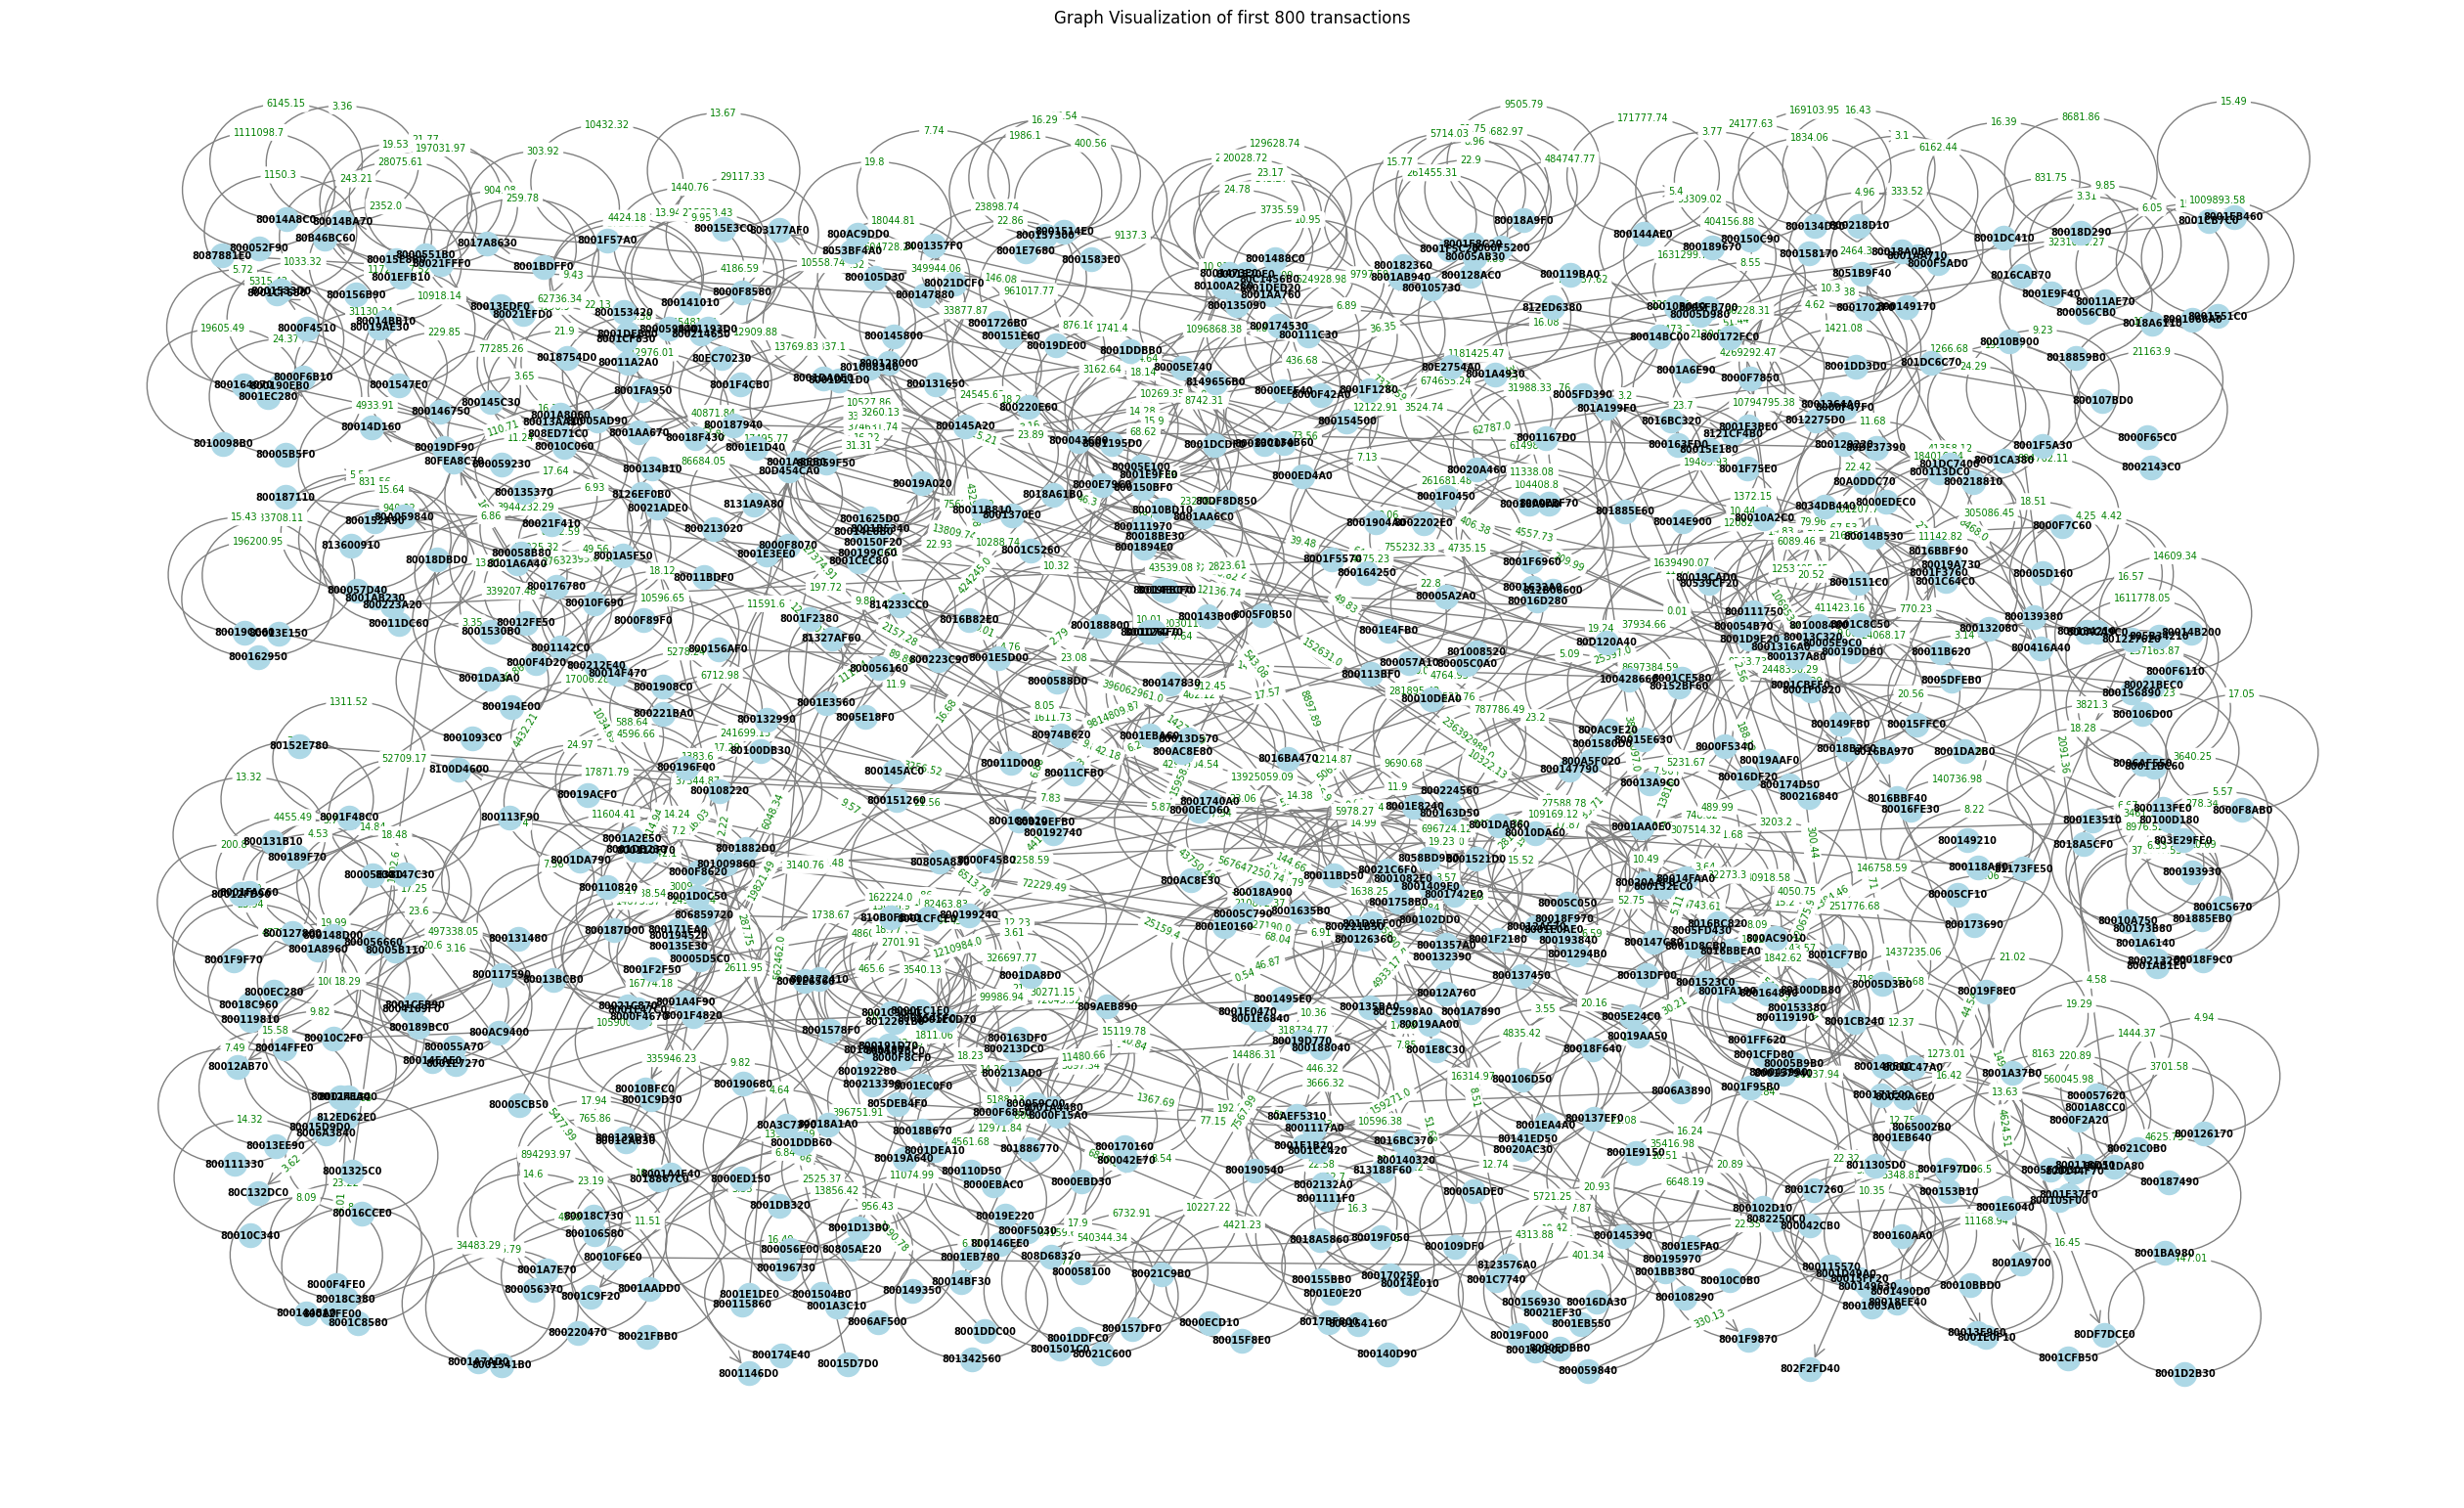

In [88]:
pos = nx.random_layout(graph) # shell, circular, spectral, spring, random, 

plt.figure(figsize=(25, 15))  # Increase figure size

nx.draw(
    graph, 
    pos, 
    node_size=300,  # Reduce node size for better visibility
    with_labels=True, 
    font_size=7, 
    font_weight='bold', 
    node_color='lightblue',  # Specify node color
    edge_color='gray',  # Specify edge color
    width=1,  # Adjust edge width
    arrows=True,  # Show arrows for directed edges
    arrowstyle='->',  # Specify arrow style
    arrowsize=20,  # Adjust arrow size
)

edge_labels = nx.get_edge_attributes(graph, 'label')
nx.draw_networkx_edge_labels(
    graph, 
    pos, 
    edge_labels=edge_labels, 
    label_pos=0.5,  # Adjust label position along edges
    font_size=7,  # Adjust font size
    font_color='green',  # Specify font color
)

plt.title(f'Graph Visualization of first {transaction_limit} transactions')  # Add title to the plot
plt.axis('off')  # Hide axis
plt.show()

In [89]:
# dictionaries 

degree_of_centrality = nx.degree_centrality(graph) # closeness_centrality, eigenvector_centrality, betweeness_centrality
betweenness_centrality = nx.betweenness_centrality(graph)

# TODO add statistics to a new dataframe

node_stat_features = pd.DataFrame()
node_stat_features['account'] = degree_of_centrality.keys()
node_stat_features['degree_of_centrality'] = degree_of_centrality.values()
node_stat_features['betweenness_centrality'] = betweenness_centrality.values()

node_stat_features

account  degree_of_centrality  betweenness_centrality
0    8000EBD30              0.002865                     0.0
1    8000F4580              0.001433                     0.0
2    8000F5340              0.001433                     0.0
3    8000F4670              0.002865                     0.0
4    8000F5030              0.002865                     0.0
..         ...                   ...                     ...
694  8001F48C0              0.002865                     0.0
695  8001F4CB0              0.002865                     0.0
696  8001F57A0              0.002865                     0.0
697  8001F5C20              0.002865                     0.0
698  800216840              0.002865                     0.0

[699 rows x 3 columns]

### --- Statistics as Features - Skip if not needed ---

In [ ]:
# Add statistics df to the original df if necessary to include

# TODO format decimal point system to exclude power values.

# node_stat_features.drop('account')

# edges_features_w_stats = pd.concat([node_features, node_stat_features], axis=1)
# edges_features_w_stats

# ADJACENCY MATRIX - nx

### --- Loading full graph ---

In [ ]:
# GETTING FULL GRAPH

graph_full = nx.Graph()

# get all links
for i in range(len(links)):
    u = links[i].get("source")
    v = links[i].get("destination")
    graph_full.add_edge(u,v,label=edges_amount[i]) # use edge labels for edge features?

In [90]:
print(len(edges_features))
print(len(links)) # number of transactions

5078345
5078345


In [95]:
print(len(unique_accounts))
print(graph_full.__len__()) # number of nodes in the graph

515080
515080


In [98]:
adjacency_matrix = nx.adjacency_matrix(graph)
adjacency_matrix = adjacency_matrix.todense()

In [99]:
print(adjacency_matrix) # index of nodes
print(len(adjacency_matrix))

[[1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
515080


# -------- !!! TODO !!! ----------

In [ ]:
# What is node2vec?

# TODO BINs sould also be vectorized to avoid ordering
# TODO binary encoding for banks --> replace 300 features with 10 features that can represent a number in binary 
# TODO take random subset from transactions

# TODO calculating time --> circular definition for months (goes back to 0) --> sinus calculations --> same time different year cannot be distinguished in unix format
# TODO --> don't do yet.

# TODO payment amount --> separate based on power of 10s --> separate columns for thousands, hundreds etc.

# TODO no need to add nodes in order --> mapping thorugh dictionary is an option

# TODO potentially add statistics to feature matrix X


In [100]:
"""
NEXT 2 WEEKS:

1. Vectorize "BANKS" - BINs using binary encoding --> DONE!!!
2. Vectorize "Amount Paid" --> DONE!!!
3. Mapping through dictionary of all links --> No need to find individual links between accounts --> we are taking all accounts and the graph in general  --> DONE!!!
4. Graph Visualization should include labels that are actual accounts  --> DONE!!!
5. Add statistics to feature matrix X? --> if necessary --> DONE!!!
6. Apply graph on subset of 1000 transactions  --> DONE!!! --> not a problem at all, efficiency is better.
7. Create Adjacency Matrix --> can be done through networkx or through existing links --> DONE!!!
7a. Get unique nodes from both "Account" and "Account.1"  --> DONE!!!

8. Create GNN model
8. Simple GNN, testing on dataset

9. Write introduction
10. Write literature review

"""

'\nNEXT 2 WEEKS:\n\n1. Vectorize "BANKS" - BINs using binary encoding --> DONE!!!\n2. Vectorize "Amount Paid" --> DONE!!!\n3. Mapping through dictionary of all links --> No need to find individual links between accounts --> we are taking all accounts and the graph in general  --> DONE!!!\n4. Graph Visualization should include labels that are actual accounts  --> DONE!!!\n5. Add statistics to feature matrix X? --> if necessary --> DONE!!!\n6. Apply graph on subset of 1000 transactions  --> DONE!!! --> not a problem at all, efficiency is better.\n7. Create Adjacency Matrix --> can be done through networkx or through existing links --> DONE!!!\n7a. Get unique nodes from both "Account" and "Account.1"  --> DONE!!!\n\n8. Create GNN model\n8. Simple GNN, testing on dataset\n\n9. Write introduction\n10. Write literature review\n\n'

# GNN

## SIMPLE GNN MODEL EXAMPLE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
num_features =
hidden_dim =
num_classes =
num_epochs =
features =
adj =
labels =

In [ ]:
class GCNBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x, adj):
        x = self.linear(x)
        x = torch.matmul(adj, x)
        x = F.relu(x)
        return x
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gcn1 = GCNBlock(input_dim, hidden_dim)
        self.gcn2 = GCNBlock(hidden_dim, output_dim)
        
    def forward(self, x, adj):
        x = self.gcn1(x, adj)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gcn2(x, adj)
        return x
# Define the model
model = GCN(num_features, hidden_dim, num_classes)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(features, adj)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()